In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
import imblearn
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.10f' % x) # round to 10 digits after 0


In [48]:
df = pd.read_csv("transaction_dataset.csv")
df = df.drop(columns=df.columns[0], axis=1) # Drop Col "Unnamed: 0"
df = df.drop(columns=df.columns[0], axis=1) # Drop Col "Index" -> something went wrong when creating DF (see CSV)

display(df.shape) # dimensions of df
display(df.info()) # Get Features + check cols for NANs + get data-types of columns

(9841, 49)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 49 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Address                                               9841 non-null   object 
 1   FLAG                                                  9841 non-null   int64  
 2   Avg min between sent tnx                              9841 non-null   float64
 3   Avg min between received tnx                          9841 non-null   float64
 4   Time Diff between first and last (Mins)               9841 non-null   float64
 5   Sent tnx                                              9841 non-null   int64  
 6   Received Tnx                                          9841 non-null   int64  
 7   Number of Created Contracts                           9841 non-null   int64  
 8   Unique Received From Addresses                        9841

None

### First Impression

We have a dataset with ~9.84k samples, 1 target columns, 47 feature columns (2 non-numeric, 45 numeric) and a column with the adresses themselves (irrelevant). Previous research (see below) indicates that the following features are most relevant for detecting fraud related accounts:
- Time Difference between first and last transaction
- Total Ether balance
- Min Value received
- Min Value sent

Thus we expect to derive similiar results in the course of this exercise.

>Farrugia, Steven, Joshua Ellul, and George Azzopardi. "Detection of illicit accounts over the Ethereum blockchain." Expert Systems with Applications 150 (2020): 113318.

<AxesSubplot:>

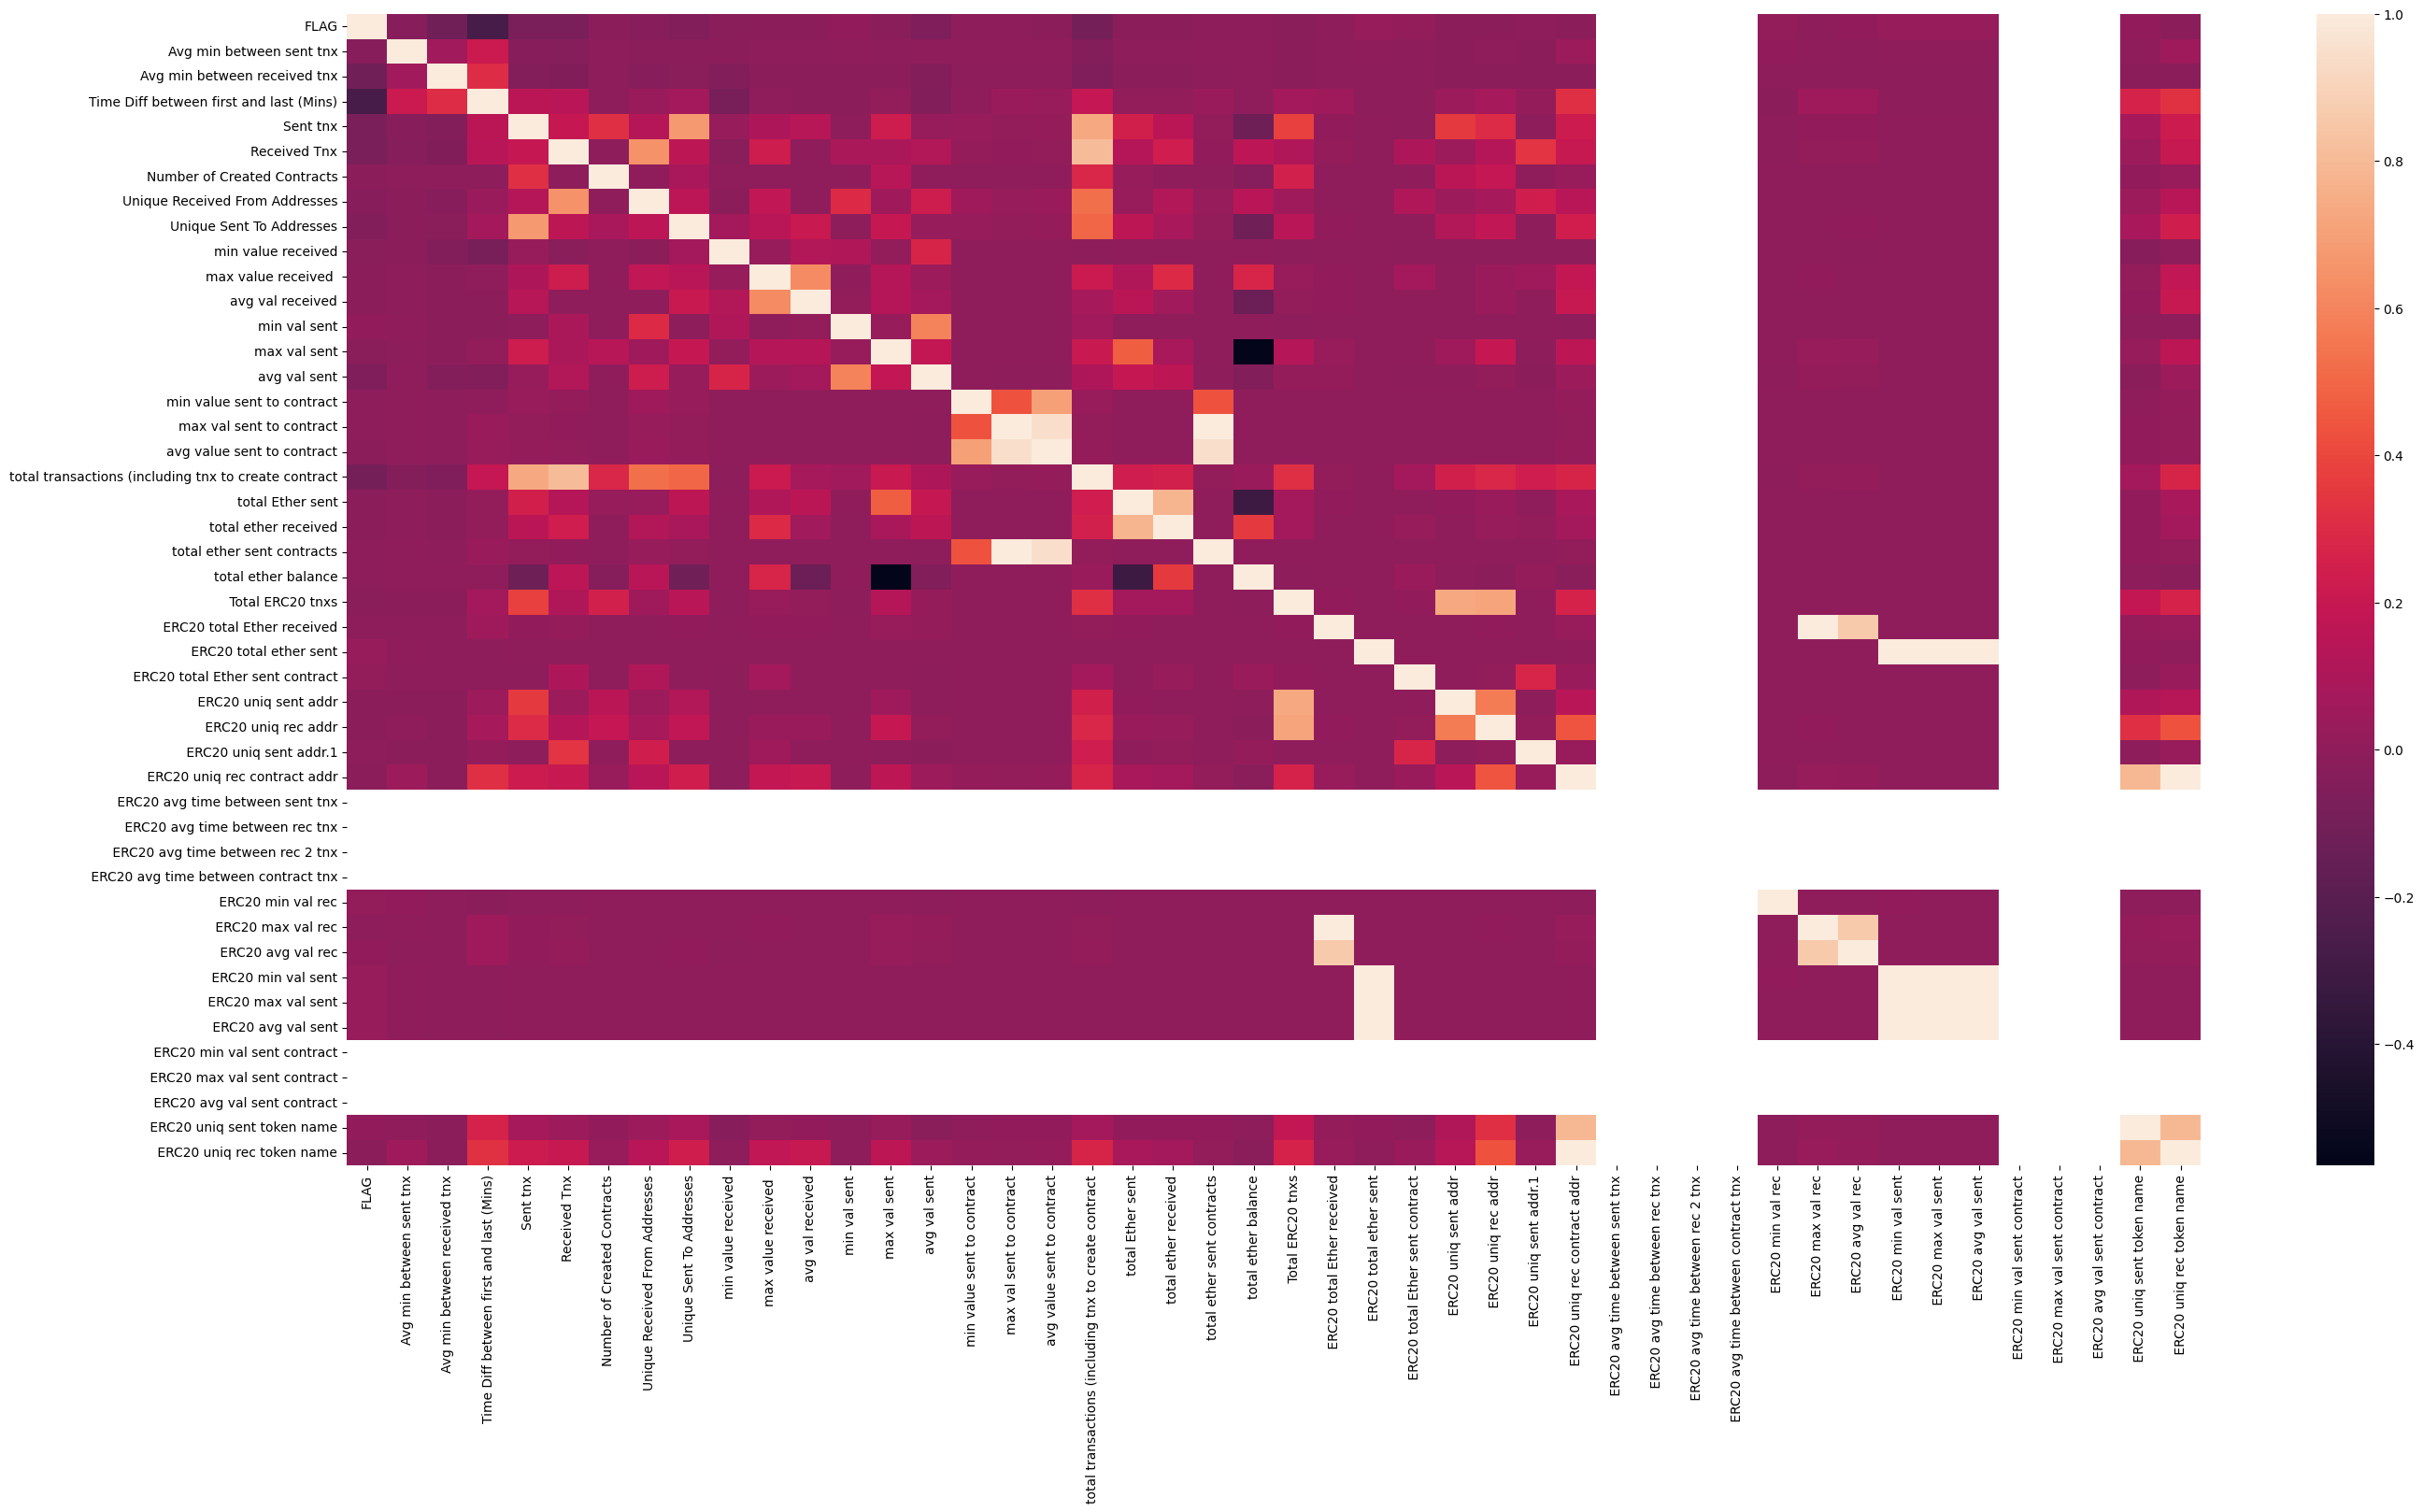

In [49]:
plt.rcParams["figure.figsize"] = (32,16) # make image large enough
corr_matrix = df.corr() # get corr
# make heatmap
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)

### Heatmap
- We can see that some features appear to have no relation with other features in the data-set. 
- These features should be removed as they most likely will not be useful in our prediction model.

In [61]:
# Cleaning & Filtering
cdf = df.copy() # copy original df
### -> "ERC20 most sent token type" + "ERC20_most_rec_token_type" + "Adress" == non-numeric
cdf = cdf.select_dtypes(include='number') # remove non-numeric columns! 
cdf = cdf.fillna(cdf.median()) # fill numeric columns with median


colvars = cdf.var() # variance for each col
colvars_zero = colvars[colvars==colvars.where(colvars < 0.000000001)] # get cals with 0 variance or very low variance
colvars_zero_names = list(colvars_zero.index) # get col names
print("Columns with 0 variance or very low variance:")
display(colvars_zero_names)
print("Dimensions before Variance Filter: "+str(cdf.shape))
cdf = cdf.drop(columns=colvars_zero_names, axis=1)
print("Dimensions after Variance Filter: "+str(cdf.shape))

Columns with 0 variance or very low variance:


[' ERC20 avg time between sent tnx',
 ' ERC20 avg time between rec tnx',
 ' ERC20 avg time between rec 2 tnx',
 ' ERC20 avg time between contract tnx',
 ' ERC20 min val sent contract',
 ' ERC20 max val sent contract',
 ' ERC20 avg val sent contract']

Dimensions before Variance Filter: (9841, 46)
Dimensions after Variance Filter: (9841, 39)


### Data Cleaning
- We remove non-numeric columns for reasons of simplification as XGBoost needs numeric variables. The new experimental feature XGBoostClassifier(enable_categorical=True) does not work for our given categorical features. It still could be possible to encode those features using Sklearn "LabelEncode", "OneHotEncode" or something similar.
- We remove features with very low variance or with 0 variance

<AxesSubplot:>

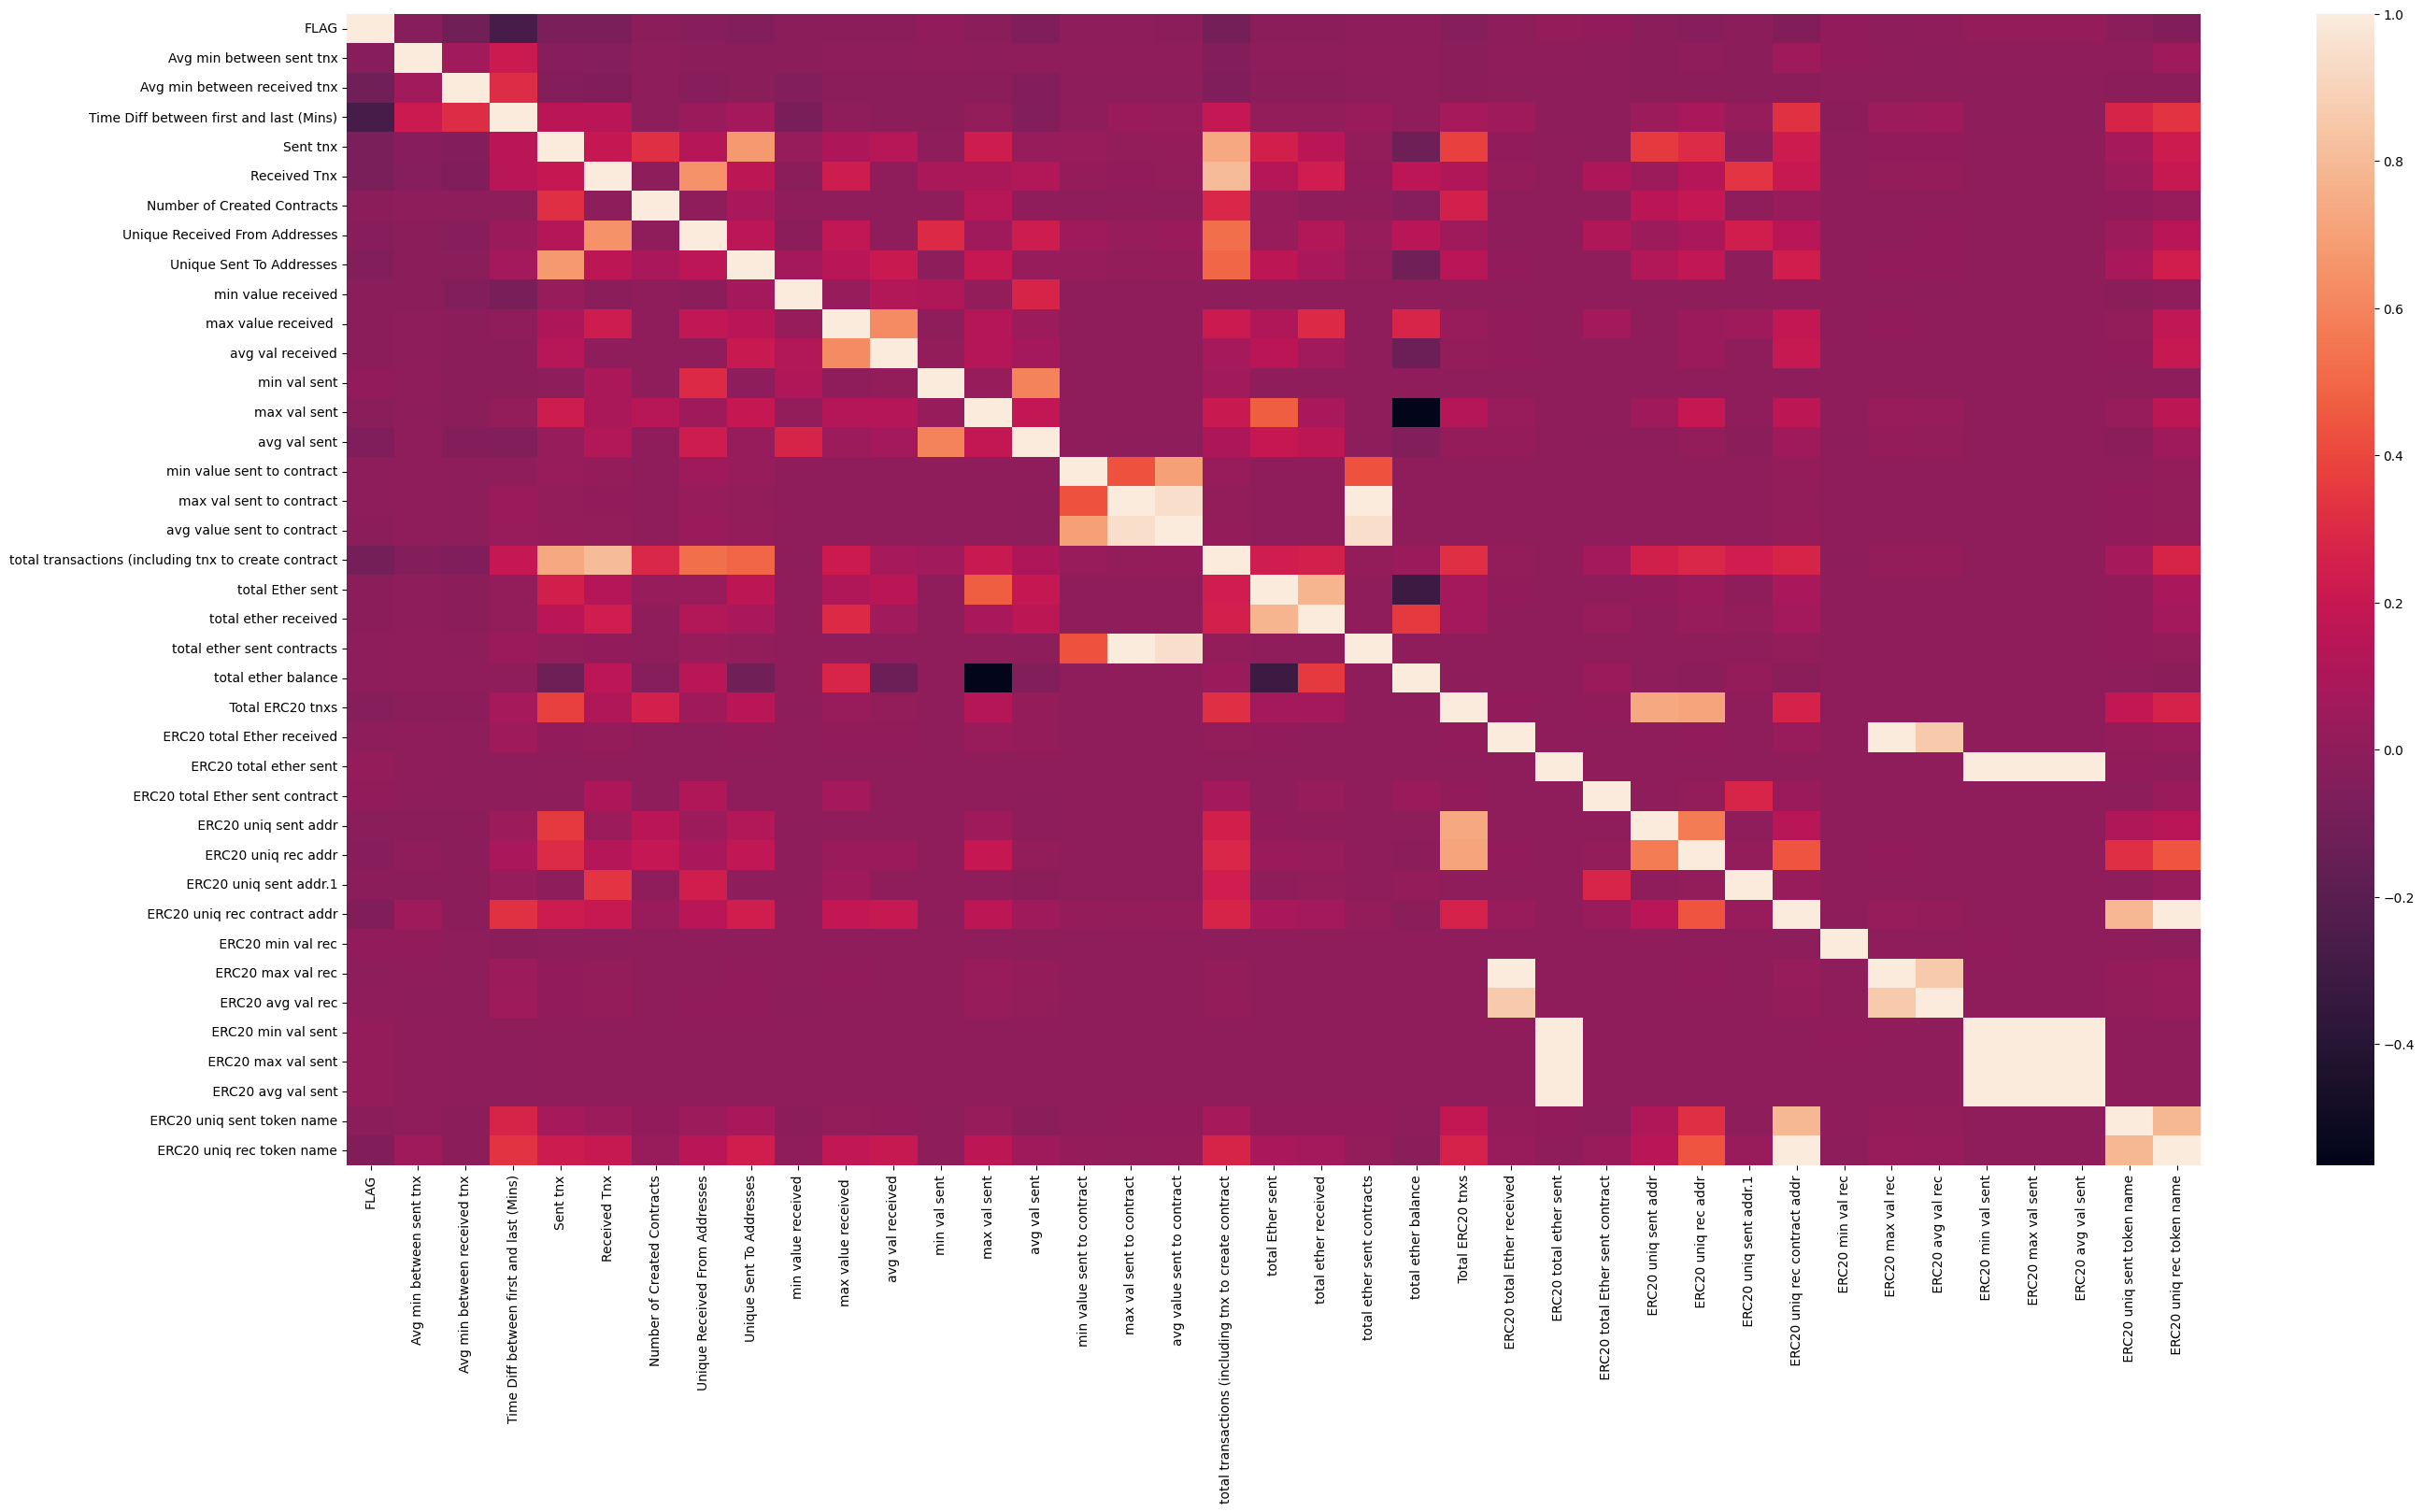

In [62]:
# Correlation Matrix on cleaned & filtered DF
corr_matrix = cdf.corr() # get corr

# make heatmap
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)

### Cleaned Feature Corr Matrix
- No big suprises
- Negative correlations: "max val sent" and "total ether balance" logical -> Wallet draining?

<AxesSubplot:>

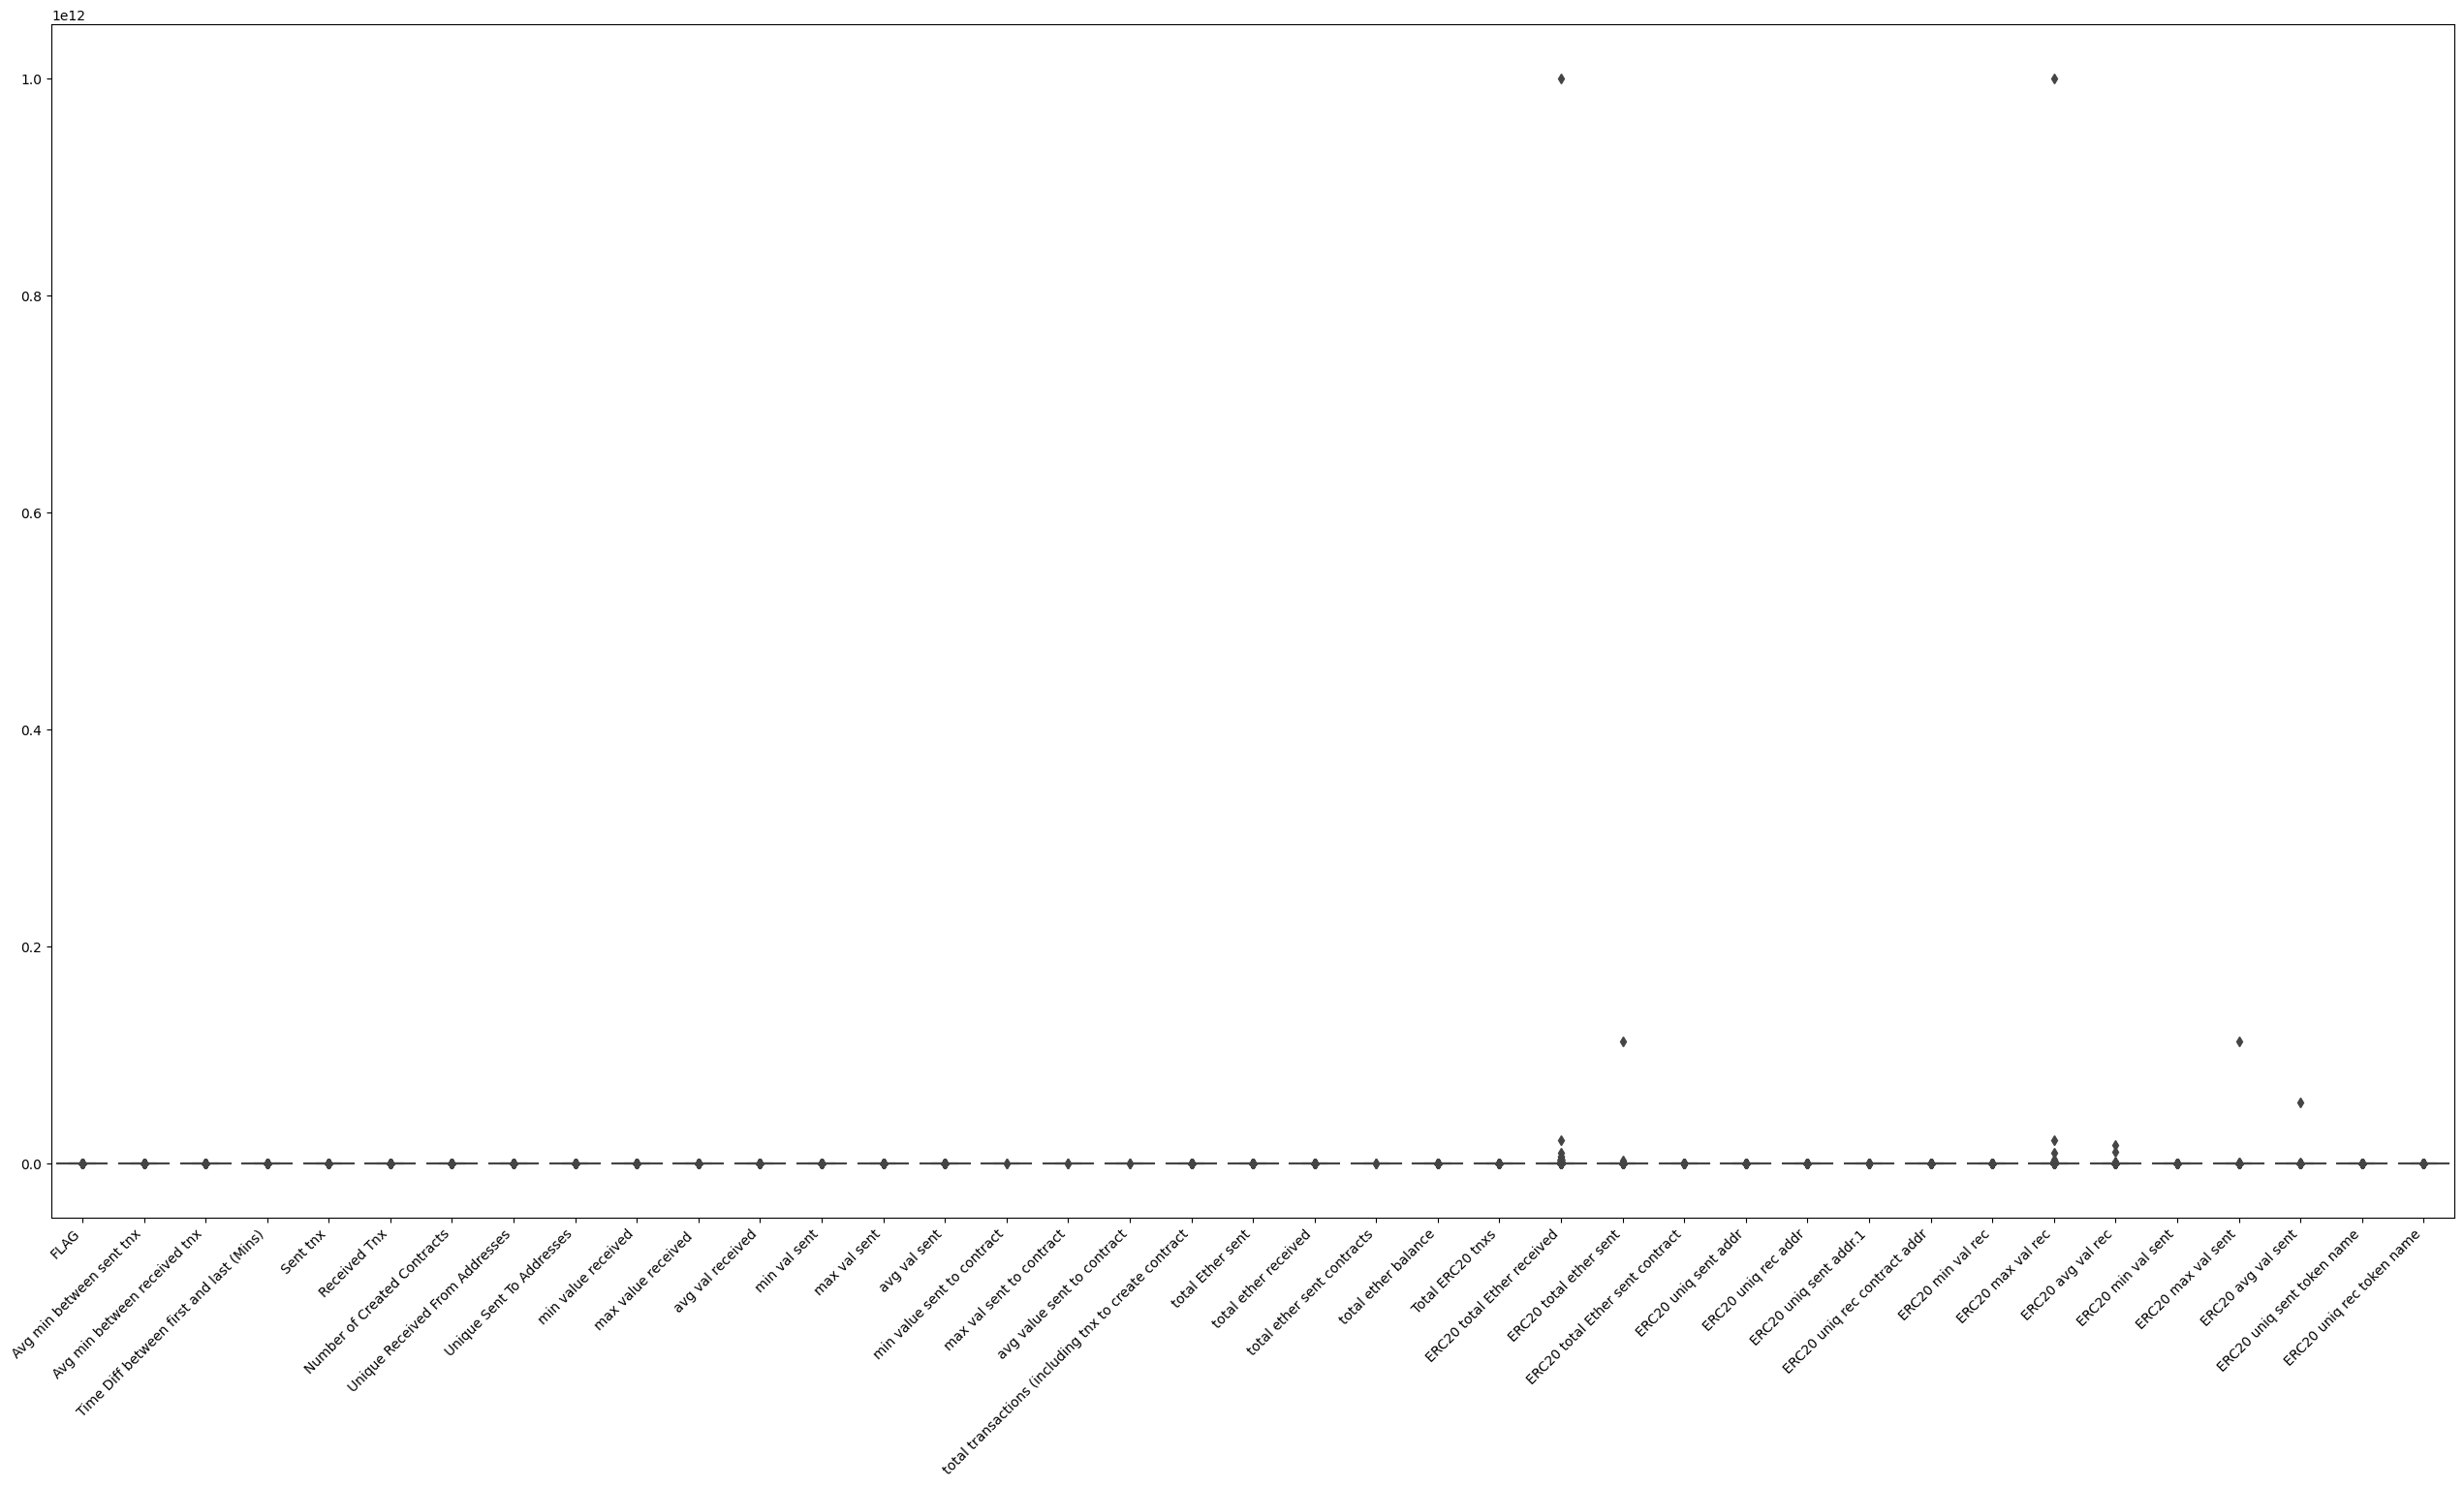

In [63]:
# Check Box-Plots
fig, ax = plt.subplots(figsize=(32, 16))
plt.xticks(rotation=45, ha='right') # rotate x-ticks so axis doesnt turn too crowded
sns.boxplot(data=cdf, ax =ax)

### Cleaned-Data-Set Boxplot
- Some features have significant outliers / extreme values, which could distort the ML model

In [64]:
# Normalization
y = cdf["FLAG"] #get target column
cdf = cdf.drop("FLAG",axis=1) #remove target col from features

ncdf=(cdf-cdf.min())/(cdf.max()-cdf.min()) # Normalize between 0 and 1

display(ncdf.head(10))

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name
0,0.0019620827,0.0022682820,0.3605298014,0.0721000000,0.0089000000,0.0000000000,0.0040004000,0.0127059330,0.0000000000,0.0000572585,...,0.0000000000,0.0741687980,0.0000000000,0.0000150000,0.0000154036,0.0000000000,0.0001502768,0.0000048405,0.1830985915,0.0773405699
1,0.0295362170,0.0061356084,0.6231730855,0.0094000000,0.0008000000,0.0000000000,0.0005000500,0.0015074836,0.0000000000,0.0000032666,...,0.0000000000,0.0089514066,0.0000000000,0.0000000004,0.0000000033,0.0000000226,0.0000000000,0.0000000000,0.0046948357,0.0094979647
2,0.5721626650,0.0050479961,0.2643304630,0.0002000000,0.0010000000,0.0000000000,0.0010001000,0.0002153548,0.0000113119,0.0000014568,...,0.0000000000,0.0102301790,0.0000000000,0.0000000004,0.0000000038,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0108548168
3,0.0237506225,0.0327372302,0.2033678661,0.0025000000,0.0009000000,0.0000000000,0.0007000700,0.0013998062,0.0000000000,0.0006250000,...,0.0000000000,0.0140664962,0.0000000000,0.0000000114,0.0000000902,0.0000010000,0.0000000806,0.0000000678,0.0046948357,0.0149253731
4,0.0000850826,0.0222072051,0.1956519823,0.4598000000,0.0020000000,0.0001000500,0.0007000700,0.0020458706,0.0000000000,0.0000160030,...,0.0000000000,0.0345268542,0.0000000000,0.0000000900,0.0000002862,0.0000000000,0.0000004018,0.0000002445,0.0281690141,0.0366350068
5,0.0230081424,0.0007787206,0.0107049455,0.0002000000,0.0003000000,0.0000000000,0.0002000200,0.0001076774,0.0000724148,0.0000060172,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
6,0.0001614269,0.0013054168,0.0044301616,0.0025000000,0.0011000000,0.0000000000,0.0009000900,0.0021535480,0.0000049000,0.0000033125,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
7,0.0034799742,0.0003667544,0.1636065471,0.0213000000,0.0005000000,0.0000000000,0.0003000300,0.0003230322,0.0000118490,0.0000025000,...,0.0000000000,0.0089514066,0.0000000000,0.0000000004,0.0000000033,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0094979647
8,0.0000000000,0.0000000000,0.0002540436,0.0001000000,0.0001000000,0.0000000000,0.0001000100,0.0001076774,0.0002000000,0.0000025000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
9,0.0059741196,0.0069186636,0.0156393221,0.0008000000,0.0003000000,0.0000000000,0.0002000200,0.0004307096,0.0000100000,0.0000500000,...,0.0000000000,0.0012787724,0.0006060606,0.0000000006,0.0000000348,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0013568521


<AxesSubplot:>

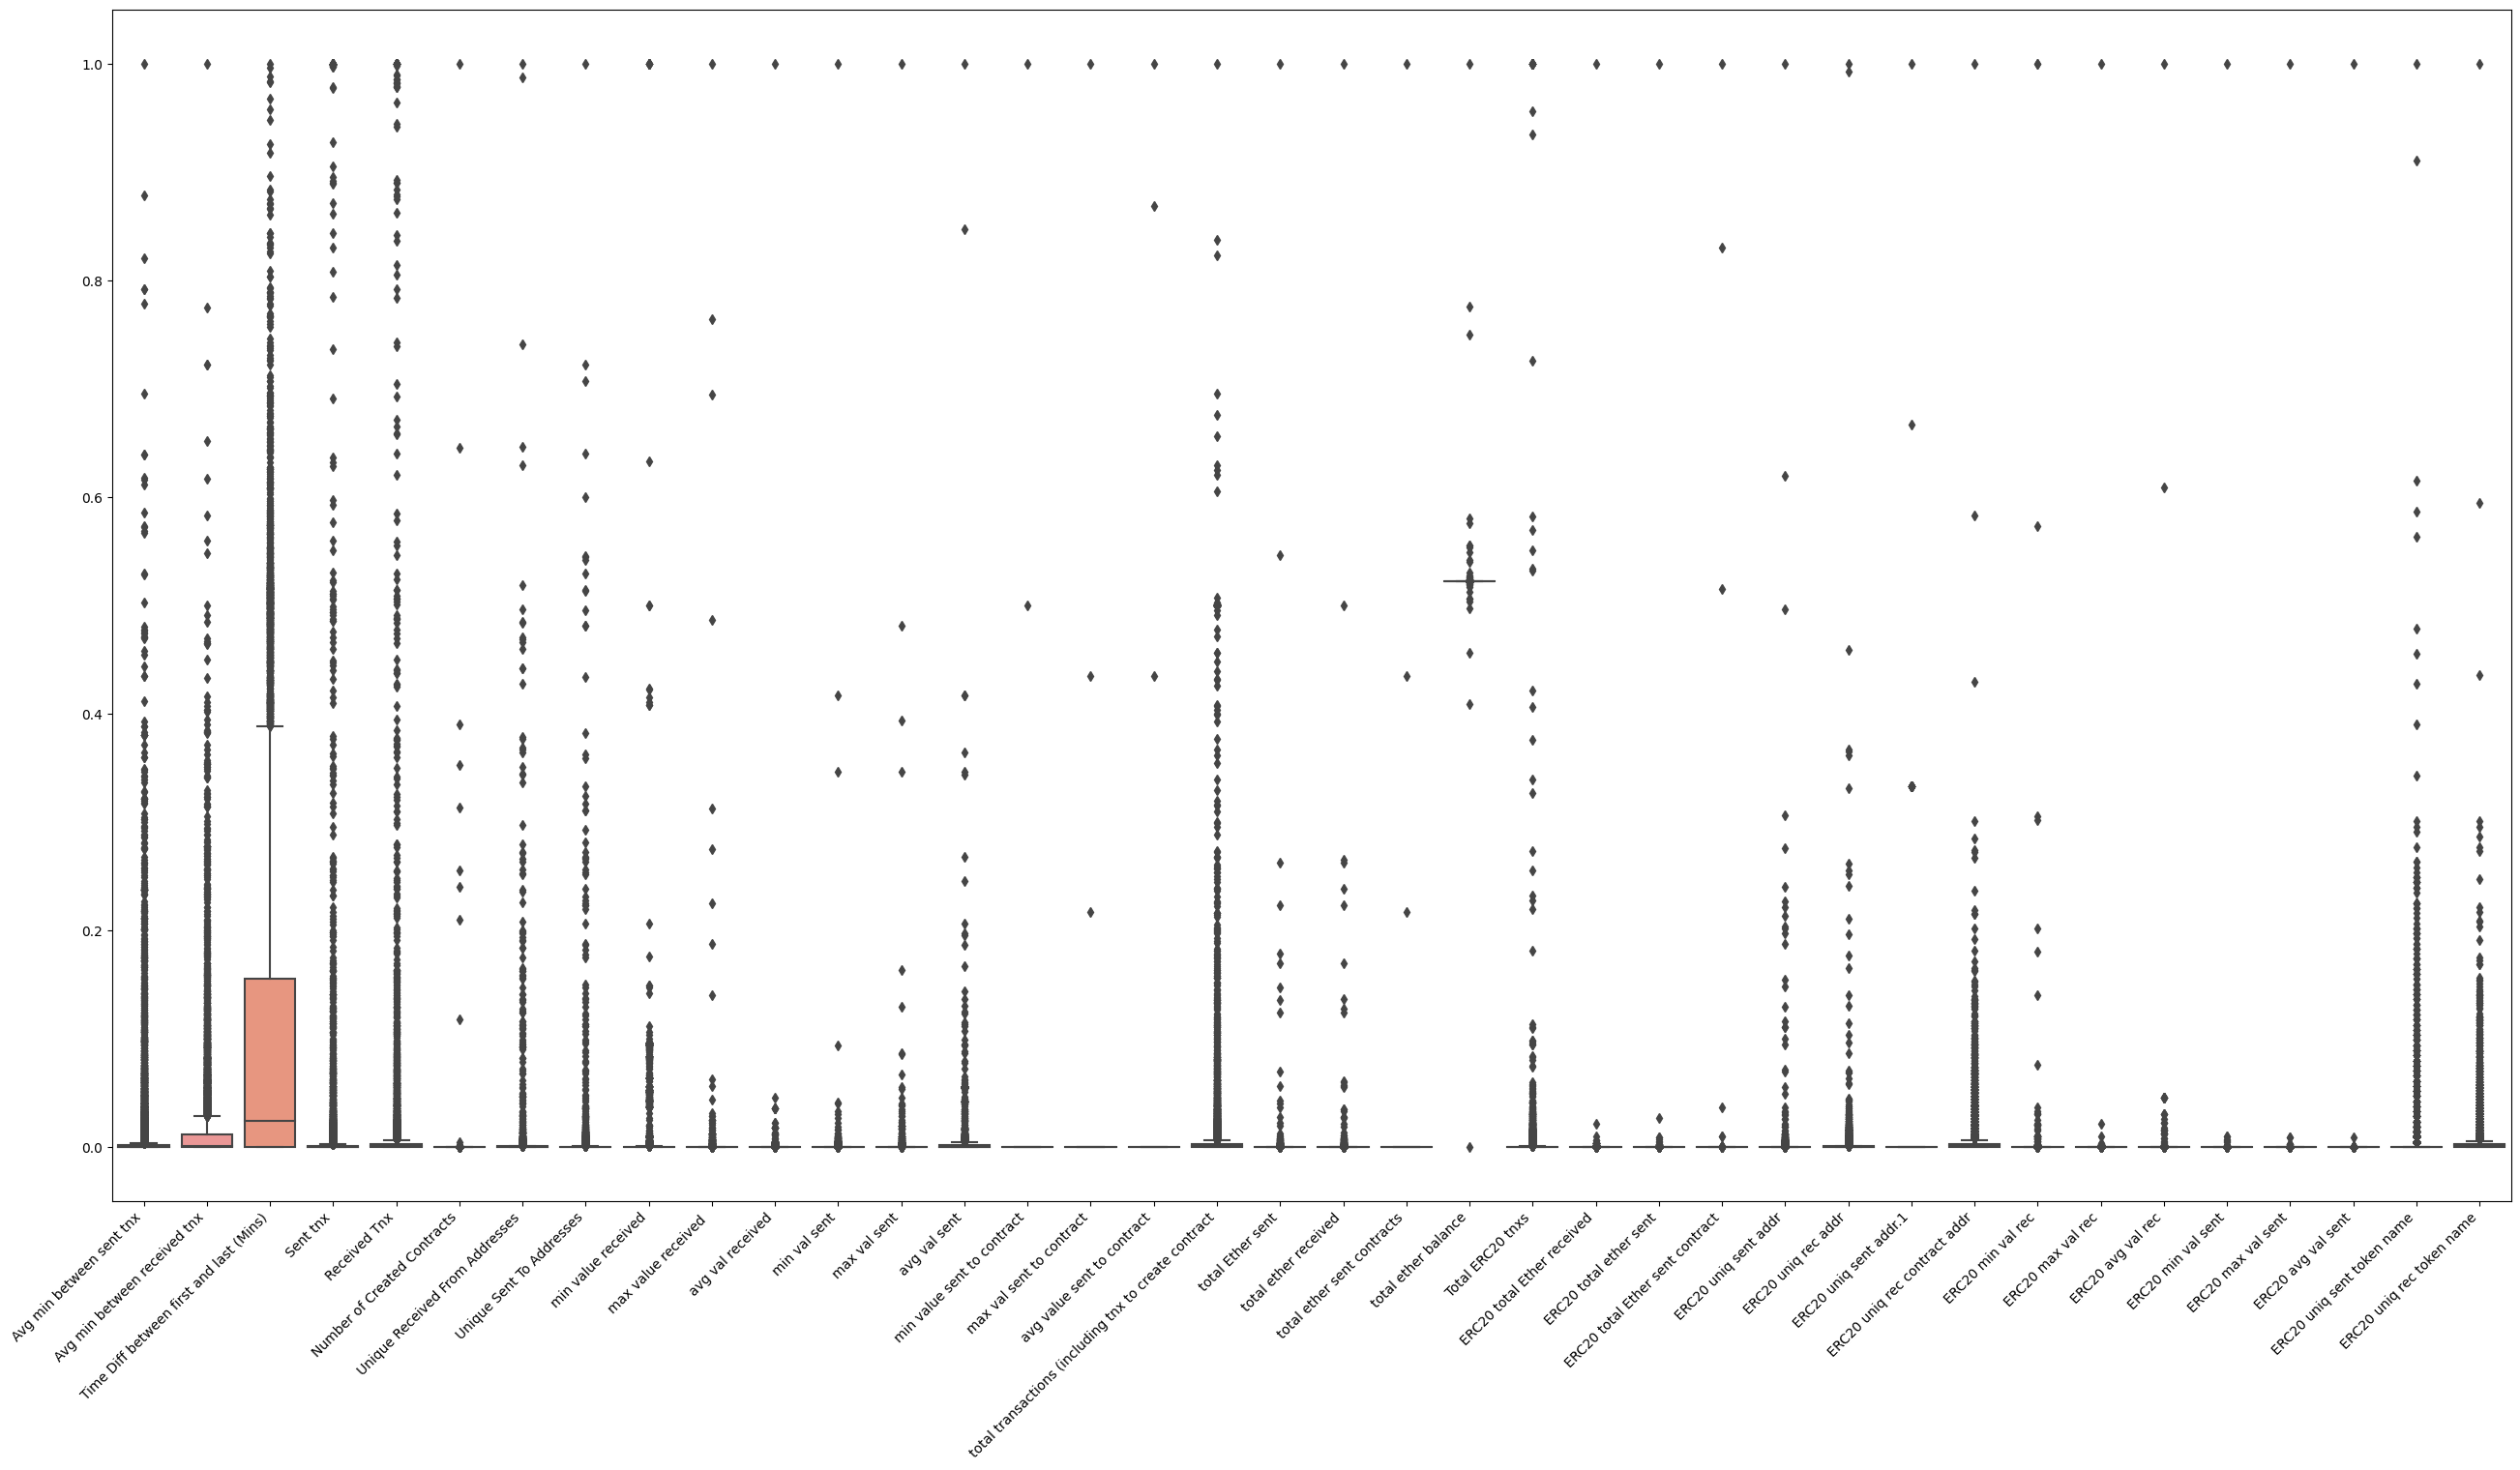

In [65]:
# Check Box-Plots
fig, ax = plt.subplots(figsize=(32, 16))
plt.xticks(rotation=45, ha='right') # rotate x-ticks so axis doesnt turn too crowded
sns.boxplot(data=ncdf, ax =ax)

### Normalized-Clean-Data-Set Box Plot
- Outliers are handeled better now.
- Most features appear to be heavily skewed towards 0

In [66]:
ycount = Counter(y)
print("Counts of Target Data: "+str(ycount))

# Train / Test Split
X = ncdf # feature df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # 80 / 20 split

# describes info about train and test set
print("\n\nDimension X_train dataset: ", X_train.shape)
print("Dimension y_train dataset: ", y_train.shape)
print("Dimension X_test dataset: ", X_test.shape)
print("Dimension y_test dataset: ", y_test.shape)

Counts of Target Data: Counter({0: 7662, 1: 2179})


Dimension X_train dataset:  (7872, 38)
Dimension y_train dataset:  (7872,)
Dimension X_test dataset:  (1969, 38)
Dimension y_test dataset:  (1969,)


### Data-Set Balance
- With twice as many negative classifications as positive, we can assume that the data-set is imbalanced

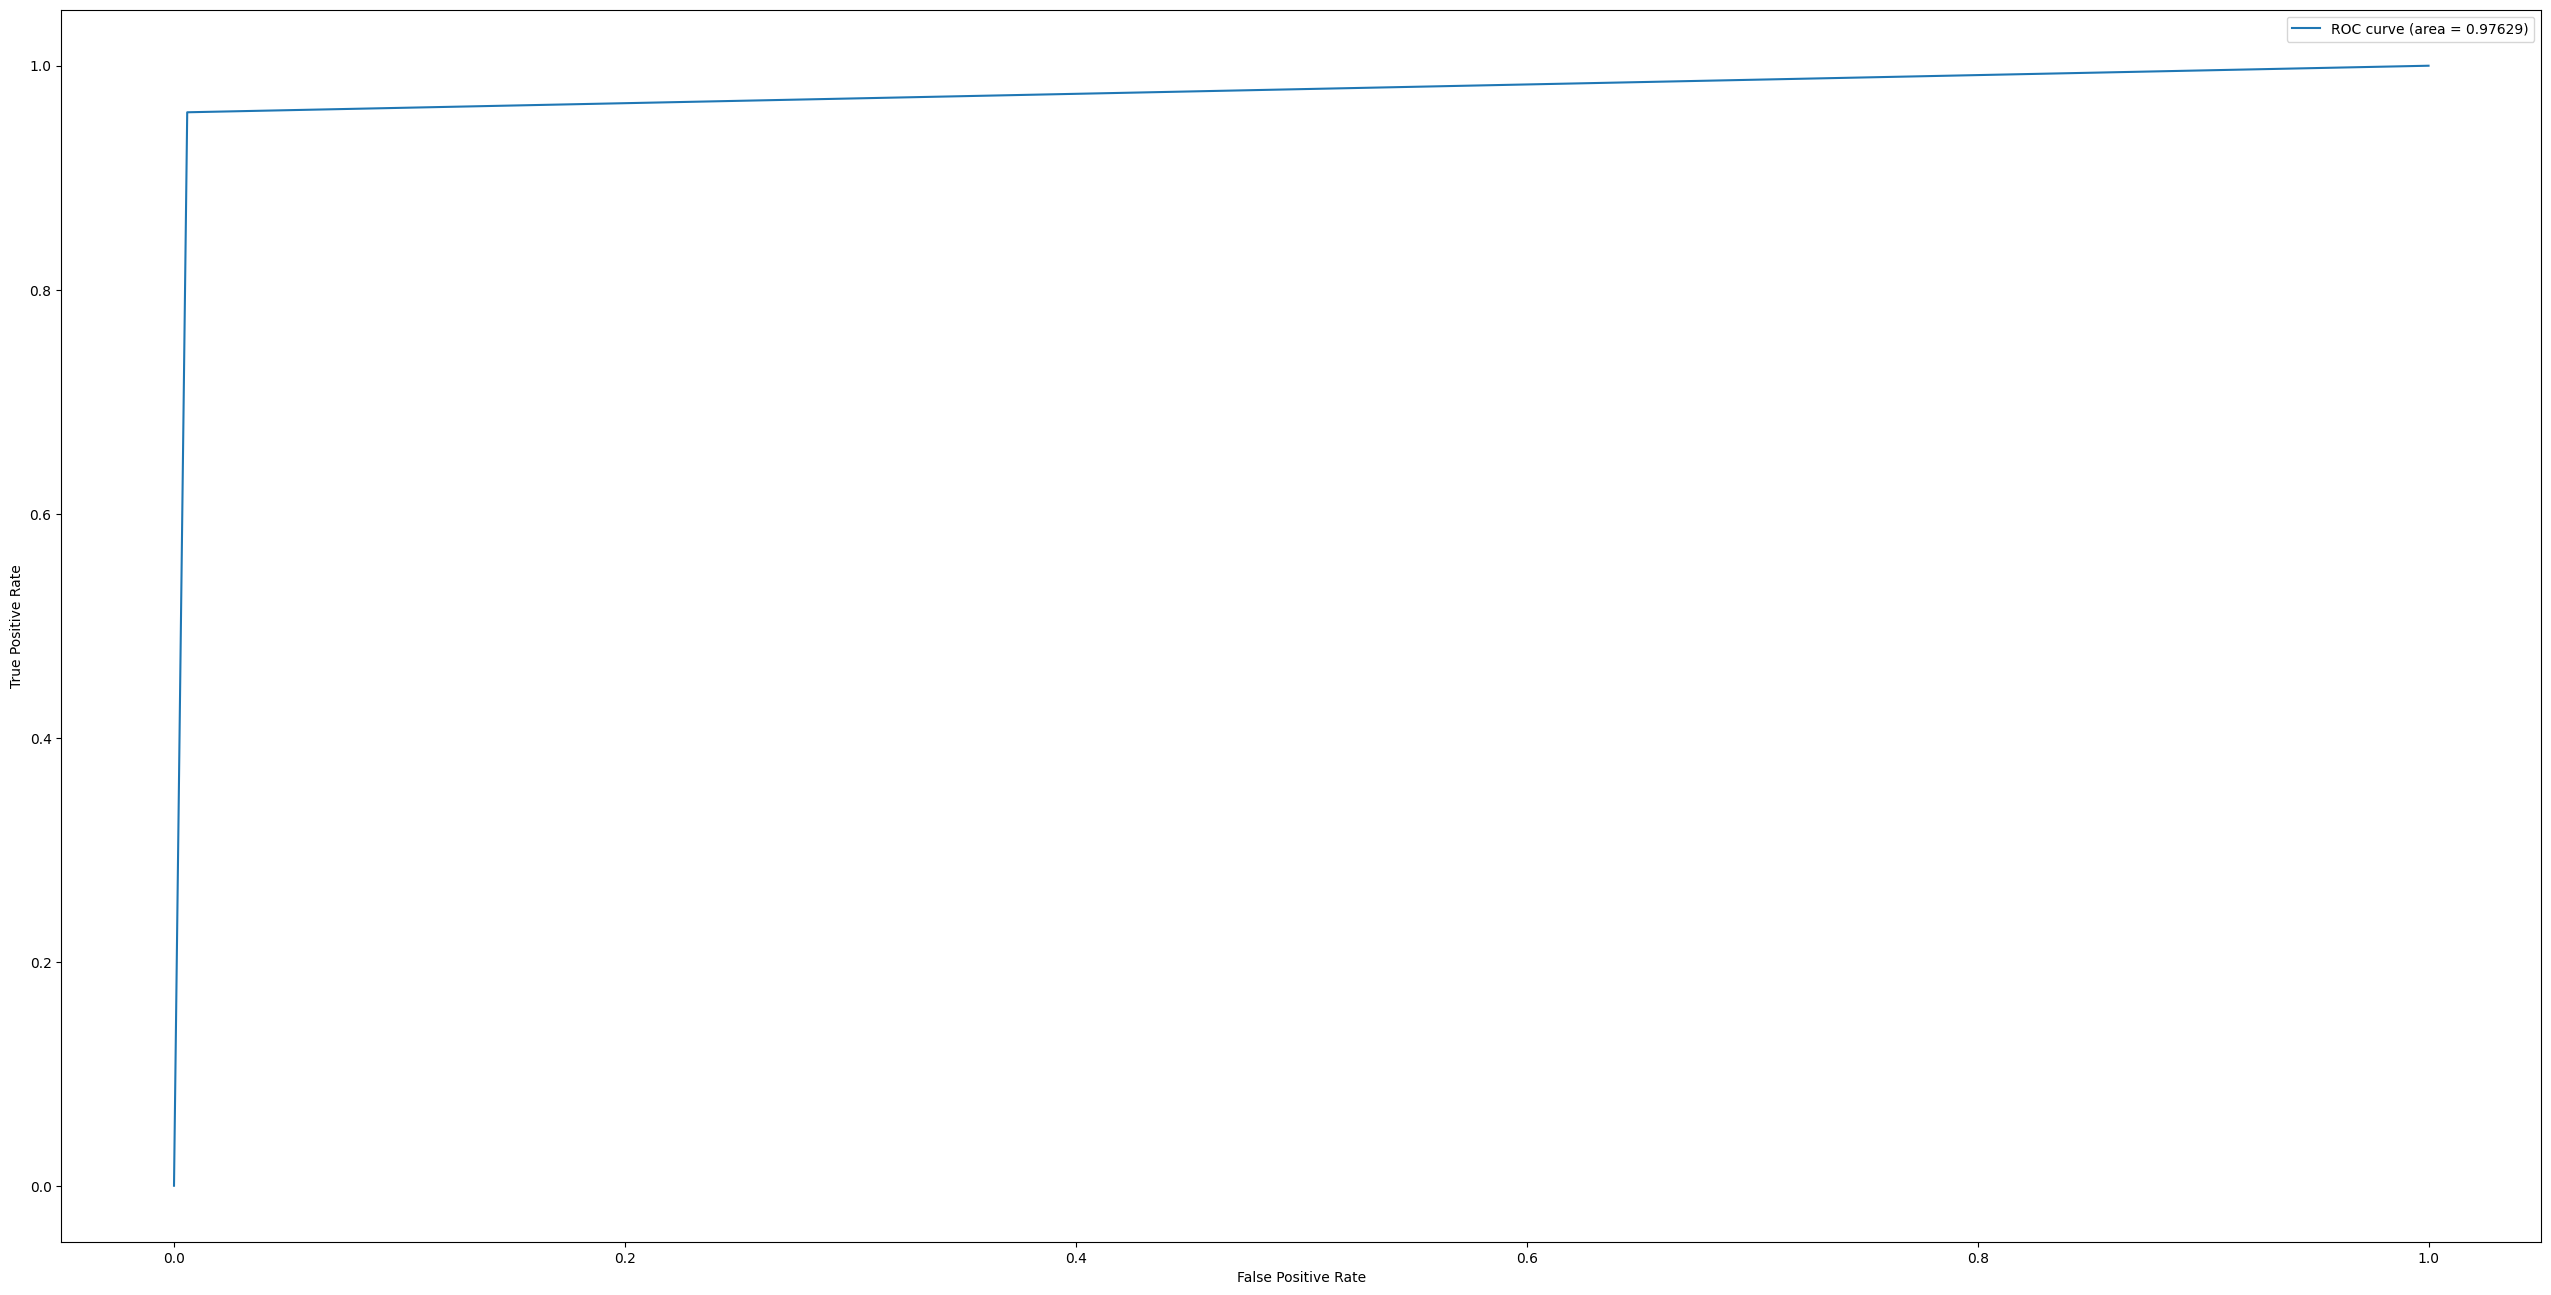

Confusion Matirx
[[1527    9]
 [  18  415]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1536
           1       0.98      0.96      0.97       433

    accuracy                           0.99      1969
   macro avg       0.98      0.98      0.98      1969
weighted avg       0.99      0.99      0.99      1969



In [67]:
# Without Balanced

# Train Model with XGB Classifier (-> bc target data = categorical!)
xgbc_model = XGBClassifier()
xgbc_model.fit(X_train, y_train)


# Predict the class labels for the test data
y_pred = xgbc_model.predict(X_test)

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
sns.lineplot(fpr, tpr, label='ROC curve (area = {:.5f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matirx")
print(cm)

# print classification report
print("\nClassification Report")
print(classification_report(y_test, y_pred))

After OverSampling, the shape of train_X: (12252, 38)
After OverSampling, the shape of train_y: (12252,) 

After OverSampling, counts of label '1': 6126
After OverSampling, counts of label '0': 6126


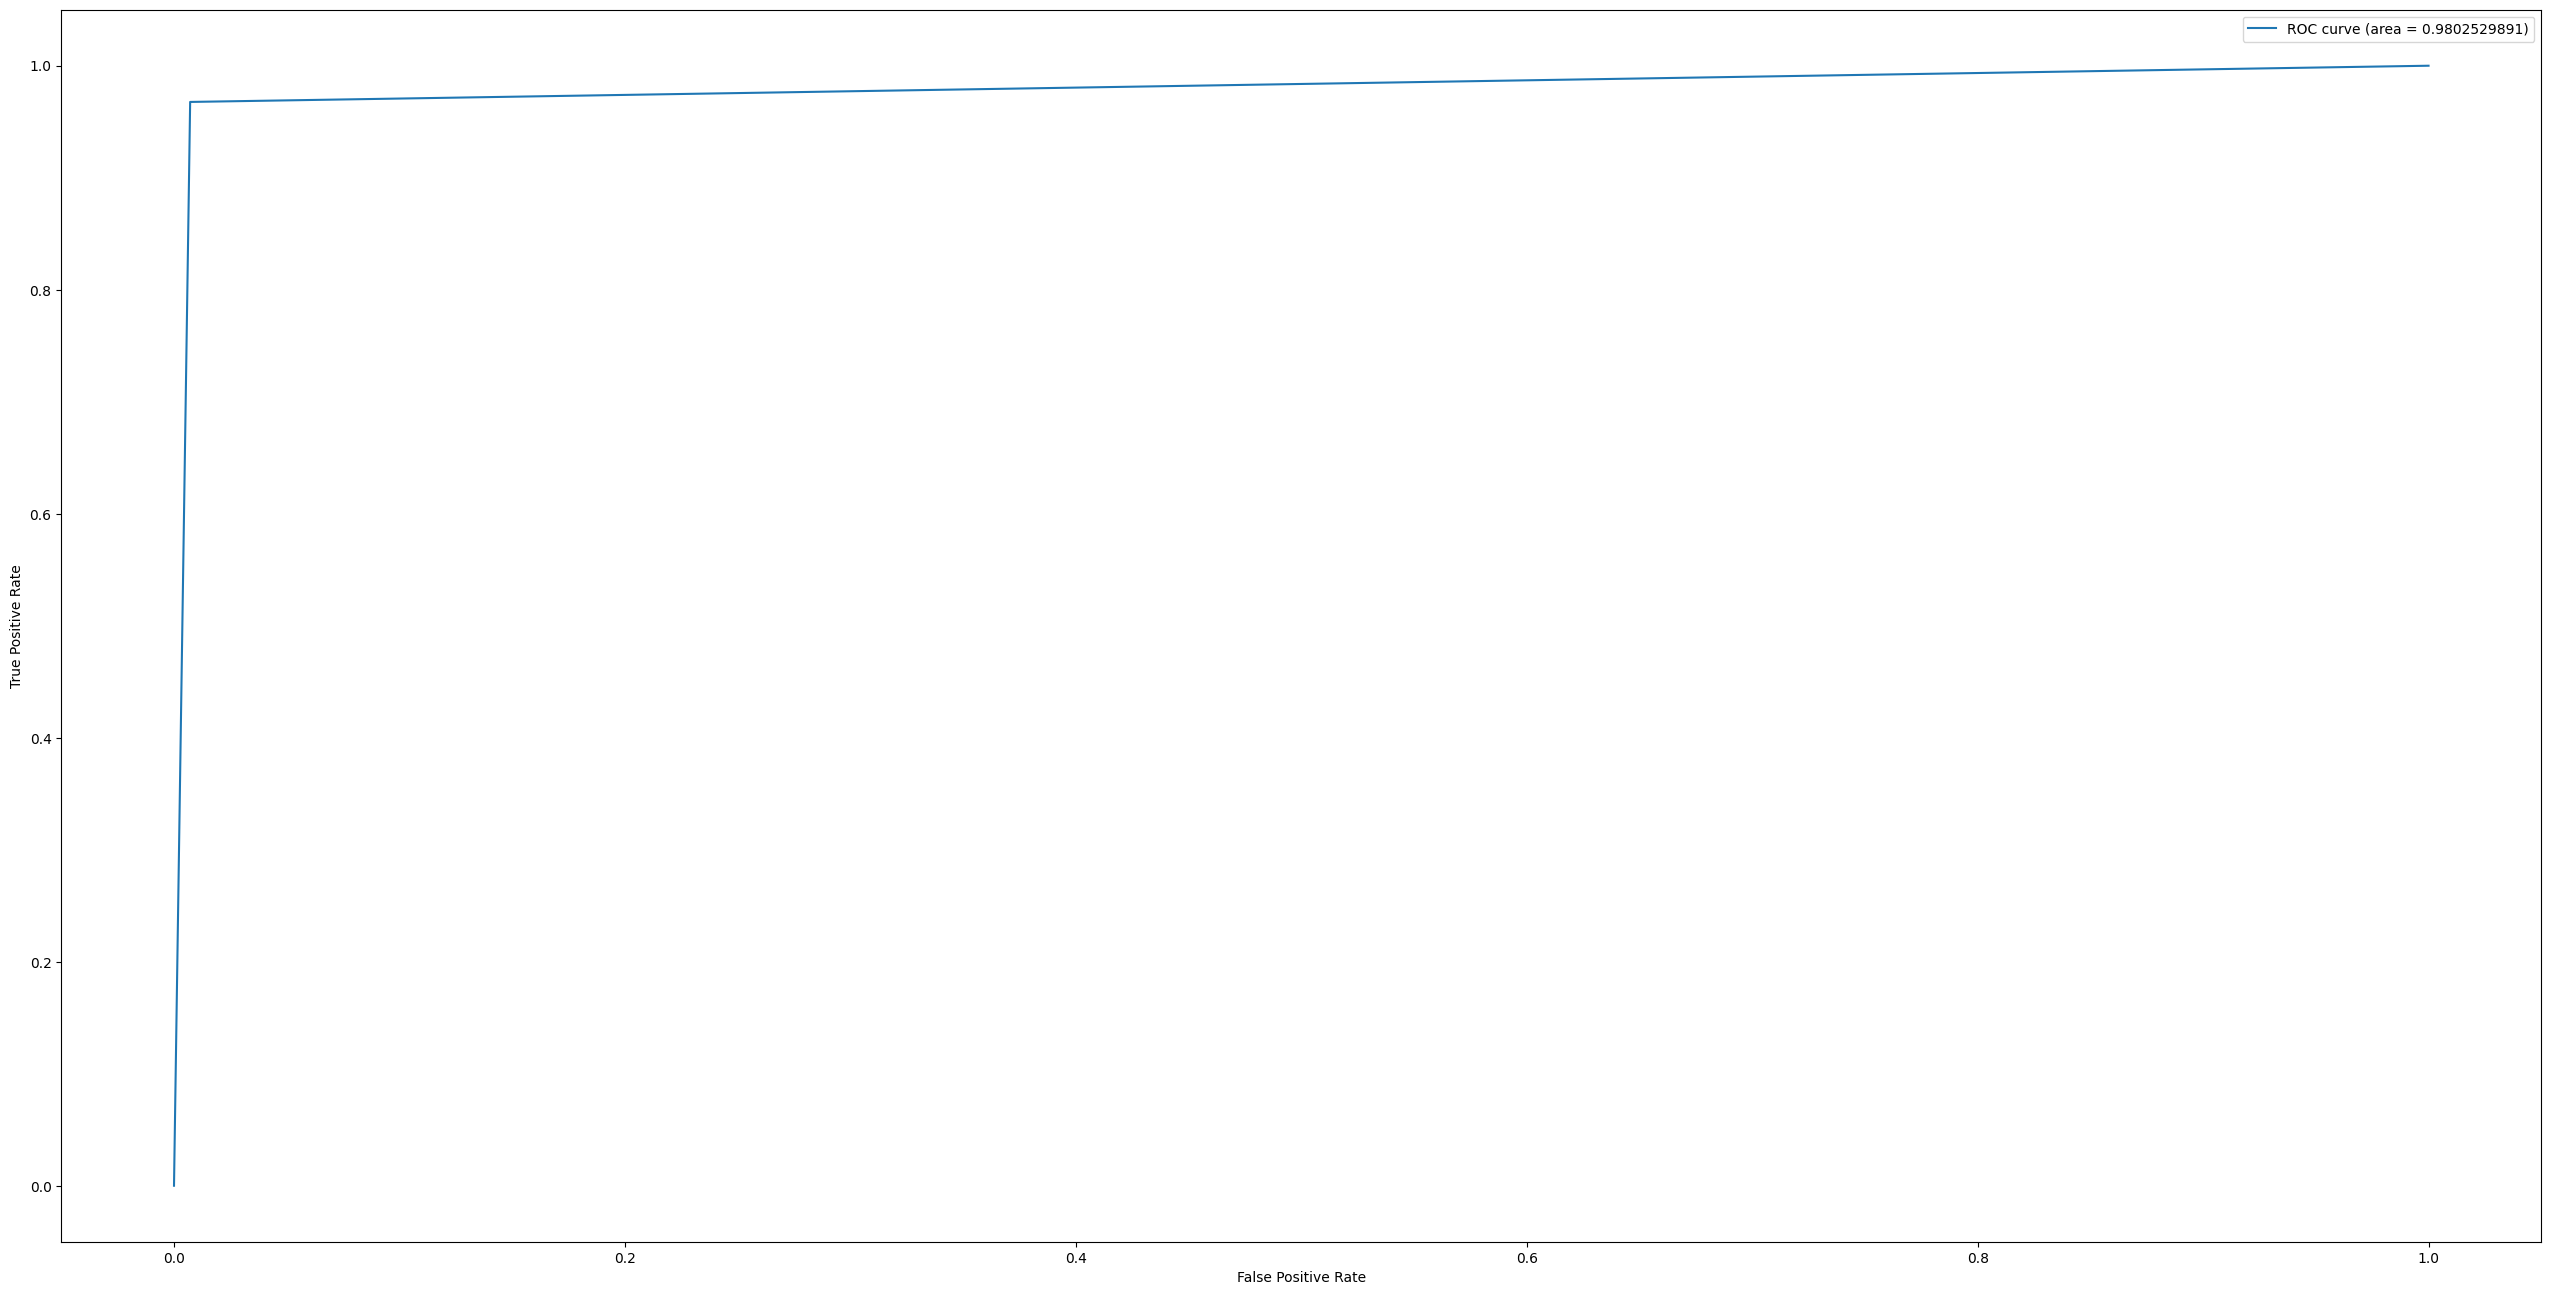


Confusion Matrix based on resampled data:
[[1525   11]
 [  14  419]]

Results of Model based on resampled data:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1536
           1       0.97      0.97      0.97       433

    accuracy                           0.99      1969
   macro avg       0.98      0.98      0.98      1969
weighted avg       0.99      0.99      0.99      1969



In [68]:
# With Balancing
from imblearn.over_sampling import SMOTE
from xgboost import cv
import xgboost as xgb

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


# Train Model with XGB Classifier (-> bc target data = categorical!)
xgbc_model = XGBClassifier()
xgbc_model.fit(X_train_res, y_train_res)

# Predict the class labels for the test data
y_pred = xgbc_model.predict(X_test)

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
sns.lineplot(fpr, tpr, label='ROC curve (area = {:.10f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("\nConfusion Matrix based on resampled data:")
print(cm)
print("\nResults of Model based on resampled data:")
print(classification_report(y_test, y_pred))

### Balancing with SMOTE & Model Performance
- Balancing the data-set using SMOTE did not improve the model perfromance significantly
- ROC/Confusion Matrix/Performance Scores show a near perfect model, in a real life case this would be a troubling result. It could be indicative of overfitting meaning that the model may not be able to generalize well to new data. 

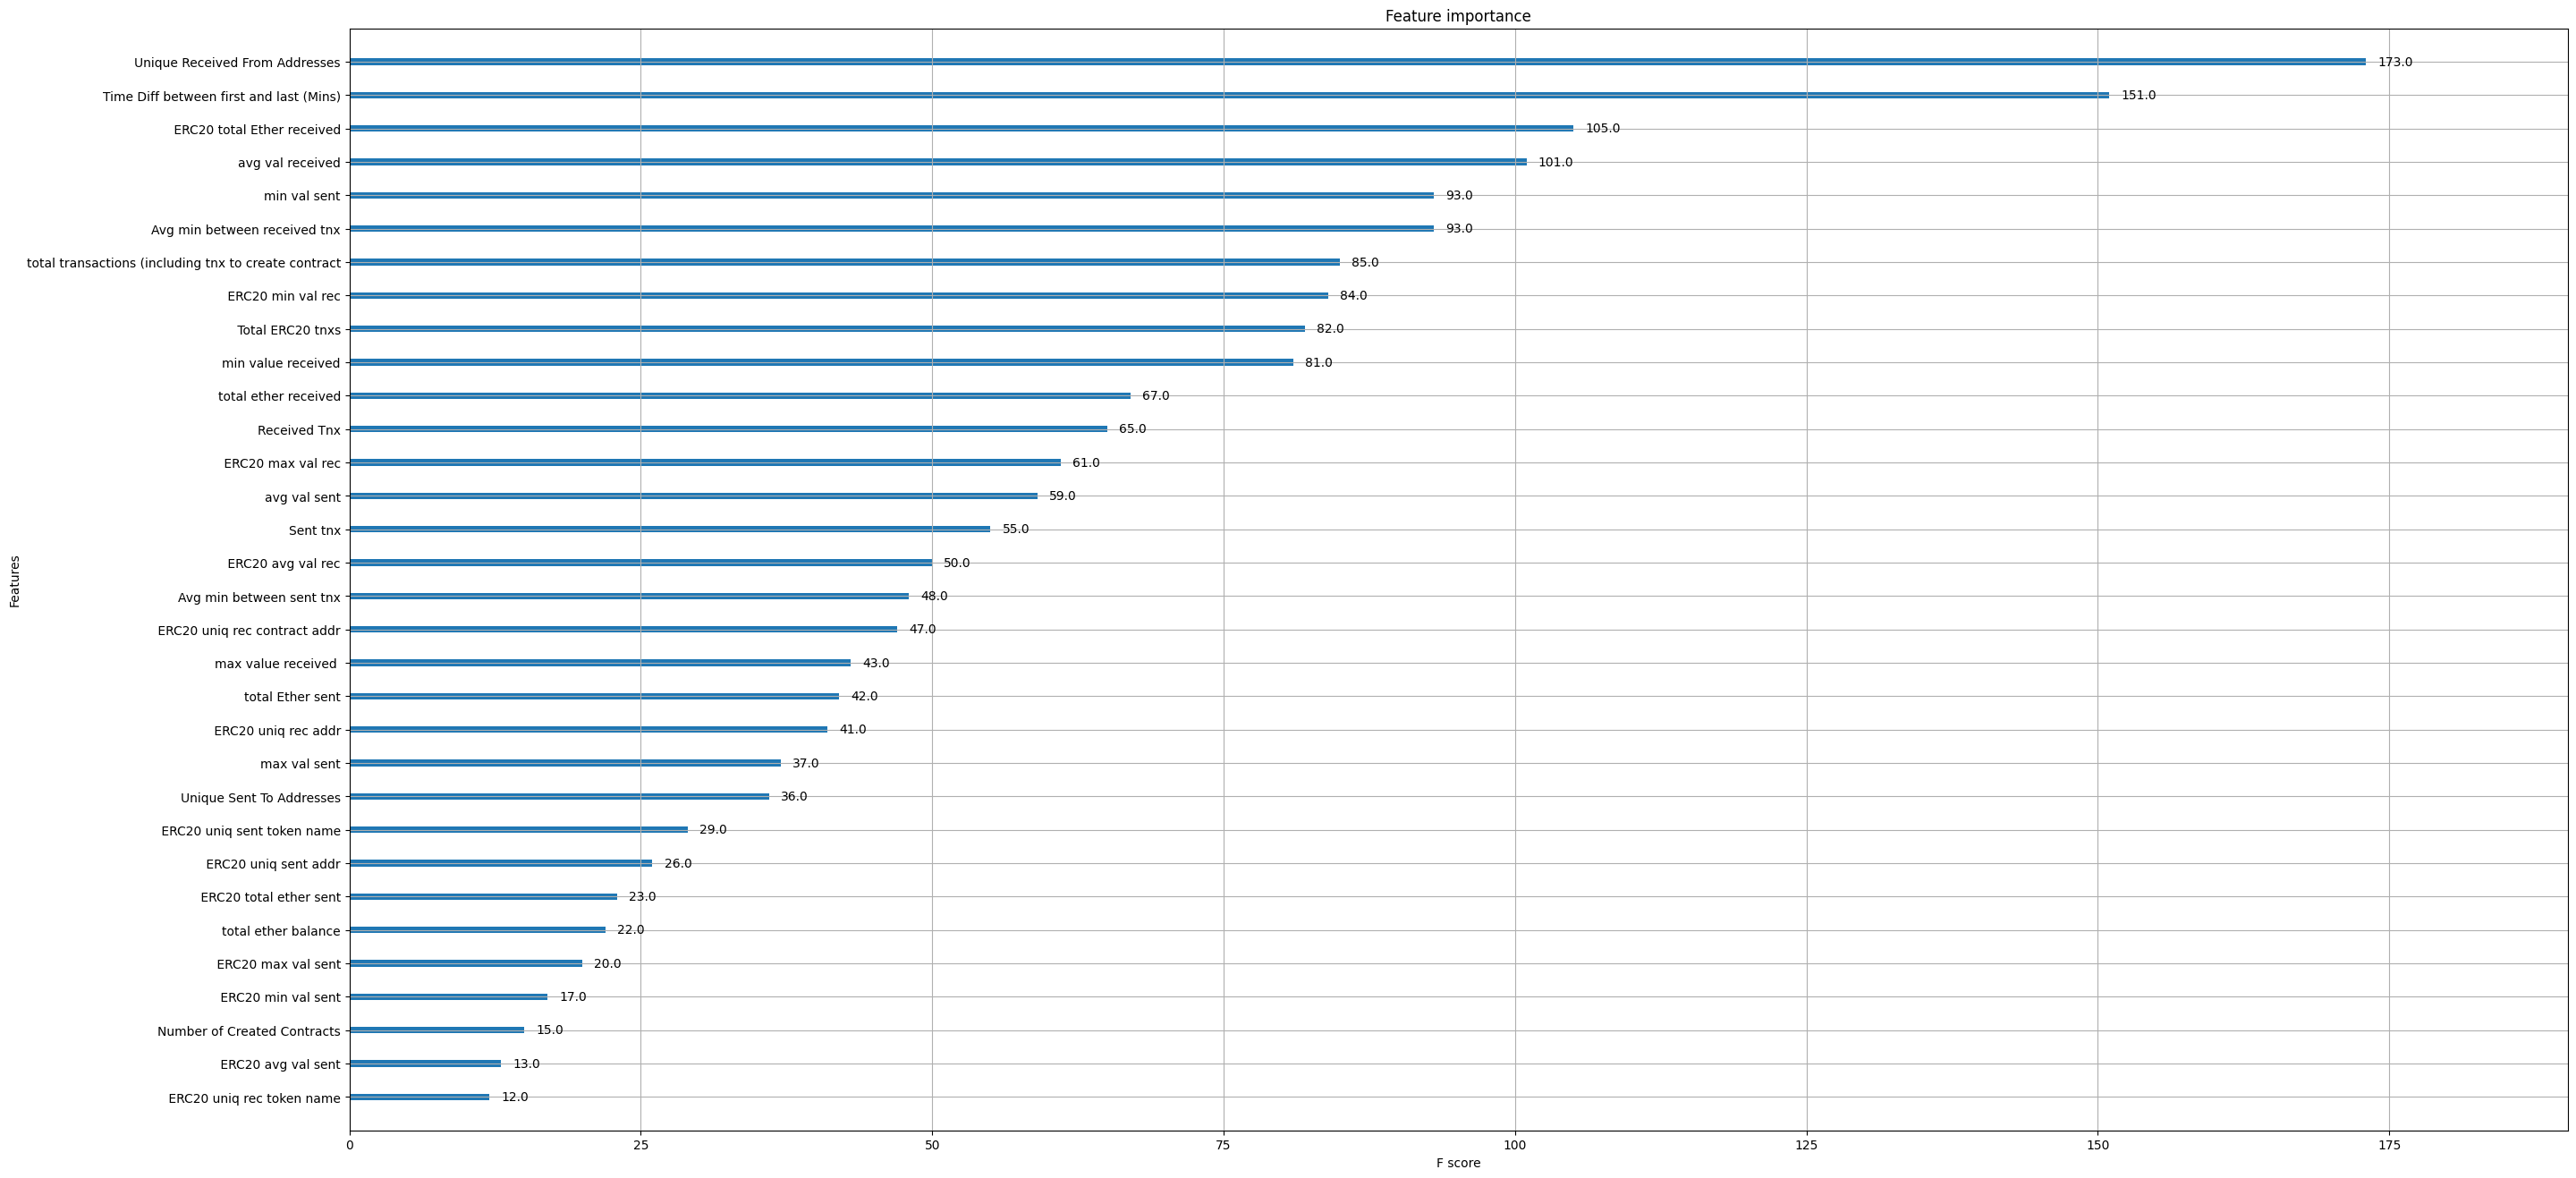

In [69]:
plot_importance(xgbc_model)
plt.show()

### Feature importance
- As we expected the top features, especially **"Time Diff between first and last TX"** being the most important one, overlap with the results of the paper referenced at the beginning of this exercise.

In [43]:
# Hyperparameters
# Source: https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
print("Default Model Params")
display(xgbc_model.get_params())

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbc_boost = XGBClassifier()

clf = GridSearchCV(estimator=xgbc_boost, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X, y)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Default Model Params


{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.5,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}
Lowest RMSE:  0.10856922191820544


In [59]:
new_params = {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}
xgbc_model = XGBClassifier(**new_params)
xgbc_model.fit(X_train_res, y_train_res)

# Predict the class labels for the test data
y_pred = xgbc_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("\nConfusion Matrix based on boosted model:")
print(cm)
print("\nResults of boosted Model:")
print(classification_report(y_test, y_pred))



Confusion Matrix based on boosted model:
[[1542    7]
 [  11  409]]

Results of boosted Model:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1549
           1       0.98      0.97      0.98       420

    accuracy                           0.99      1969
   macro avg       0.99      0.98      0.99      1969
weighted avg       0.99      0.99      0.99      1969



### Hyperparameter Tuning
- Model Performance already good with default params.
- Parameter Tuning with GridSearch is slow, but exhaustive.
- Using the suggested parameters from [Source](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663) we do not get a significantly better performance compared with default params.